# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [63]:
import sys
sys.path.insert(0, './Utilities/')

# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1+cu113 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install matplotlib==3.5.1 scipy==1.7.3 scikit-learn==1.0.2 pandas==1.4.2 seaborn==0.11.2
import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
# !pip install scipy
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [64]:
# CUDA support 
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
device = torch.device('cpu')

## Physics-informed Neural Networks

In [65]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [71]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X, compute_f=True):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        if not compute_f:
            u = u.detach().cpu().numpy()
            return u, None
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [72]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Non-noisy Data

In [73]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

Loss: 2.212378e-02, l1: 0.21152, l2: 0.00193
Loss: 1.580099e-02, l1: 0.51824, l2: 0.00248
Loss: 1.295481e-02, l1: 0.65912, l2: 0.00321
Loss: 9.527219e-03, l1: 0.71479, l2: 0.00441
Loss: 6.233673e-03, l1: 0.75154, l2: 0.00503
Loss: 4.043175e-03, l1: 0.82968, l2: 0.00525
Loss: 3.140653e-03, l1: 0.84955, l2: 0.00513
Loss: 2.392781e-03, l1: 0.88950, l2: 0.00503
Loss: 1.656841e-03, l1: 0.91889, l2: 0.00481
Loss: 1.150937e-03, l1: 0.96237, l2: 0.00458
Loss: 7.720031e-04, l1: 0.97037, l2: 0.00438
Loss: 5.792130e-04, l1: 0.97627, l2: 0.00424
Loss: 3.890540e-04, l1: 0.97870, l2: 0.00391
Loss: 2.829765e-04, l1: 0.98020, l2: 0.00369
Loss: 2.183109e-04, l1: 0.98196, l2: 0.00357
Loss: 1.768560e-04, l1: 0.98389, l2: 0.00347
Loss: 1.521130e-04, l1: 0.98571, l2: 0.00341
Loss: 1.361207e-04, l1: 0.99076, l2: 0.00338
Loss: 1.198575e-04, l1: 0.98892, l2: 0.00327
Loss: 1.028234e-04, l1: 0.99442, l2: 0.00321
Loss: 8.703828e-05, l1: 0.99153, l2: 0.00313
Loss: 7.833065e-05, l1: 0.98964, l2: 0.00312
Loss: 6.60

In [75]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 1.504862e-03
Error l1: 0.04097%
Error l2: 0.83613%


## Training on Noisy Data

In [8]:
noise = 0.01    

# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)            

It: 0, Loss: 3.837e-01, Lambda_1: -0.001, Lambda_2: 0.002476
It: 100, Loss: 8.474e-02, Lambda_1: 0.020, Lambda_2: 0.002321
It: 200, Loss: 3.426e-02, Lambda_1: 0.056, Lambda_2: 0.002177
It: 300, Loss: 2.861e-02, Lambda_1: 0.083, Lambda_2: 0.002185
It: 400, Loss: 2.432e-02, Lambda_1: 0.131, Lambda_2: 0.002168
It: 500, Loss: 2.165e-02, Lambda_1: 0.180, Lambda_2: 0.002177
It: 600, Loss: 1.922e-02, Lambda_1: 0.229, Lambda_2: 0.002218
It: 700, Loss: 1.551e-02, Lambda_1: 0.300, Lambda_2: 0.002264
It: 800, Loss: 1.242e-02, Lambda_1: 0.376, Lambda_2: 0.002331
It: 900, Loss: 1.058e-02, Lambda_1: 0.433, Lambda_2: 0.002430
It: 1000, Loss: 1.560e-02, Lambda_1: 0.481, Lambda_2: 0.002539
It: 1100, Loss: 9.653e-03, Lambda_1: 0.447, Lambda_2: 0.002544
It: 1200, Loss: 8.722e-03, Lambda_1: 0.481, Lambda_2: 0.002591
It: 1300, Loss: 7.937e-03, Lambda_1: 0.511, Lambda_2: 0.002641
It: 1400, Loss: 7.179e-03, Lambda_1: 0.540, Lambda_2: 0.002694
It: 1500, Loss: 6.434e-03, Lambda_1: 0.569, Lambda_2: 0.002747
It:

## Visualizations

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


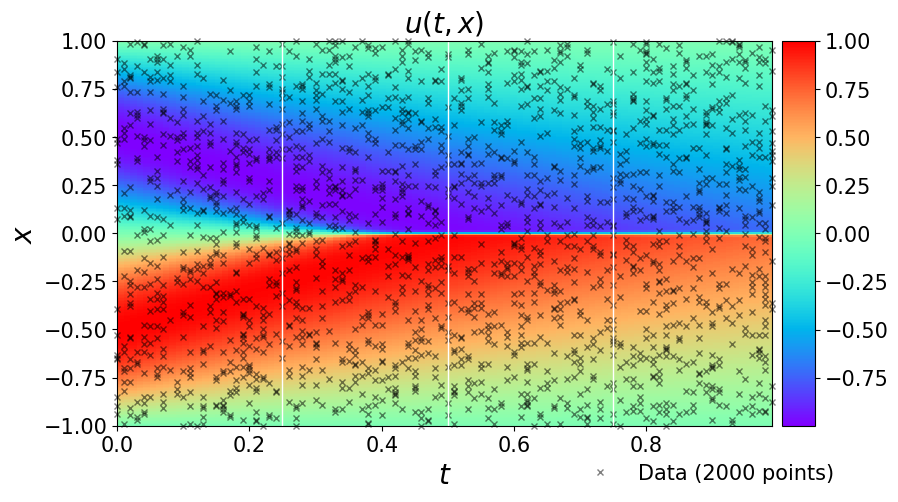

In [13]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    
plt.rcParams['text.usetex'] = False
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

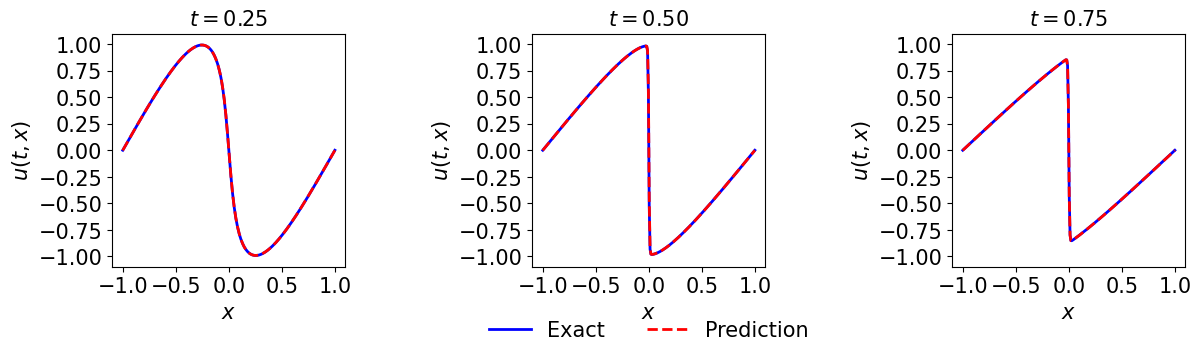

In [14]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [15]:
# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))    

Error u: 3.282830e-03
Error l1: 0.15298%
Error l2: 0.24536%


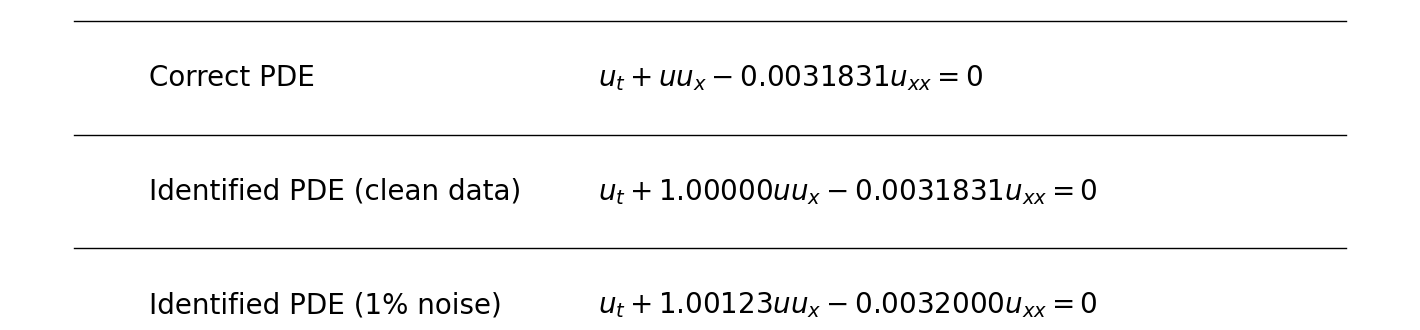

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ------------------------------------------

# Define dummy values for lambda_1_value, lambda_2_value, etc., for the code to be runnable.
# In your actual script, these would come from your calculations.
lambda_1_value = 1.00000
lambda_2_value = 0.0031831
lambda_1_value_noisy = 1.00123
lambda_2_value_noisy = 0.0032000

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

# Define base coordinates for text
base_x = 0.1
base_y = 0.75 # Start higher up, adjust as needed
line_spacing = 0.1 # Vertical spacing between lines
col_spacing = 0.3 # Horizontal spacing between columns

ax.text(base_x, base_y, 'Correct PDE', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y, '$u_t + u u_x - 0.0031831 u_{xx} = 0$', size=20, ha='left', va='center')

# Row 2 (clean data)
ax.text(base_x, base_y - line_spacing, 'Identified PDE (clean data)', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y - line_spacing, '$u_t + %.5f u u_x - %.7f u_{xx} = 0$' % (lambda_1_value, lambda_2_value), size=20, ha='left', va='center')

# Row 3 (1% noise)
ax.text(base_x, base_y - 2 * line_spacing, 'Identified PDE (1% noise)', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y - 2 * line_spacing, '$u_t + %.5f u u_x - %.7f u_{xx} = 0$' % (lambda_1_value_noisy, lambda_2_value_noisy), size=20, ha='left', va='center')

# Optional: Add horizontal lines manually if you want the table look
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y + line_spacing/2, base_y + line_spacing/2], color='black', linewidth=1)
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y - line_spacing/2, base_y - line_spacing/2], color='black', linewidth=1)
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y - 3*line_spacing/2, base_y - 3*line_spacing/2], color='black', linewidth=1) # Added third line
plt.show()

In [83]:
# Quantize the model (CPU only) and evaluate its error
import torch

# Move model to CPU for quantization
model.dnn.cpu()

# Apply dynamic quantization to Linear layers
quantized_dnn = torch.quantization.quantize_dynamic(
    model.dnn, {torch.nn.Linear}, dtype=torch.float16 # torch.float16, torch.qint8
)

# Evaluate quantized model on CPU
model.dnn = quantized_dnn  # Replace with quantized model

# Make sure input is on CPU
X_star_cpu = X_star.astype(np.float32)
u_pred_q, f_pred_q = model.predict(X_star_cpu, False)

error_u_q = np.linalg.norm(u_star-u_pred_q,2)/np.linalg.norm(u_star,2)

print('Quantized model error u: %e' % (error_u_q))

Quantized model error u: 7.708930e-02


# Results
Original Model's L2 Loss: 1.504862e-03

Quantized (qint8) Model's L2 Loss: 7.708930e-02

Quantized (float16) Model's L2 Loss: 7.708930e-02